# Part I: Python Backtesting Code

In [1]:
from ib_insync import *
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 7497, clientId = 34)

<IB connected to 127.0.0.1:7497 clientId=34>

In [2]:
from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
#import statsmodels
#import statsmodels.api as sm
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
#from xml.etree import ElementTree as ET
#from IPython.core.debugger import set_trace
import seaborn as sns
import random
from ta import add_all_ta_features
from ta.utils import dropna
from ta.trend import *

In [3]:
# endtime = datetime.today()
endtime = '20210201'
endtime = datetime.strptime(endtime, "%Y%m%d")
#define a function to get IB data. endDate is the last date of the historical data 
def get_data(contract, history, freq, side, endDate = endtime):
    
    bar = ib.reqHistoricalData(
        contract,
        endDateTime = endDate,
        durationStr=history,
        barSizeSetting= freq,
        whatToShow=side,
        useRTH=True,
        formatDate=1)

In [4]:
endtime

datetime.datetime(2021, 2, 1, 0, 0)

In [5]:
'''
Bilibili (NASDAQ:BILI) is sometimes described as China's Netflix. 
While both companies don't exactly have the same business models and target different markets, 
they both draw on original and new content to capture the hearts and eyeballs of stay-at-home viewers.
'''
# More information: https://finance.yahoo.com/quote/BILI/
ticker = "BILI"
contract = Contract(symbol = ticker, secType = 'STK', exchange = 'SMART',currency = 'USD')
ib.qualifyContracts(contract)

# Grab price and volume data from IB
bar = ib.reqHistoricalData(
        contract,
        endDateTime = endtime,
        durationStr = '2 Y', # we need this rather than '1 Y' for out indicators, maybe there is a better way to do so.
        barSizeSetting = '1 day',
        whatToShow = 'Trades',
        useRTH = True,
        formatDate = 1)

# Convert the bar data into pandas dataframe
df = util.df(bar) # last trade
#check the top 5 rows
df.head()

,date,open,high,low,close,volume,average,barCount
0,2019-01-31,18.32,18.460,17.96,18.41,43978,18.254600,18215
1,2019-02-01,18.30,18.610,17.75,17.83,26442,18.060335,13876
2,2019-02-04,17.89,18.050,17.47,17.70,20996,17.774915,11582
3,2019-02-05,17.76,18.435,17.66,18.21,18658,18.140635,8551
4,2019-02-06,18.19,18.480,18.07,18.21,17012,18.304445,8489


In [6]:
df

,date,open,high,low,close,volume,average,barCount
0,2019-01-31,18.3200,18.4600,17.9600,18.41,43978,18.254600,18215
1,2019-02-01,18.3000,18.6100,17.7500,17.83,26442,18.060335,13876
2,2019-02-04,17.8900,18.0500,17.4700,17.70,20996,17.774915,11582
3,2019-02-05,17.7600,18.4350,17.6600,18.21,18658,18.140635,8551
4,2019-02-06,18.1900,18.4800,18.0700,18.21,17012,18.304445,8489
5,2019-02-07,17.9900,18.0648,16.9900,17.18,37590,17.377830,14830
6,2019-02-08,16.9900,17.6500,16.4300,17.46,15484,17.154030,7013
7,2019-02-11,17.8300,17.9500,17.1500,17.29,21689,17.380105,10746
8,2019-02-12,17.5100,18.2100,17.5100,17.86,36191,17.896170,19208
9,2019-02-13,18.1100,18.5000,17.9635,18.20,22676,18.280330,10438


In [7]:
df.tail()

,date,open,high,low,close,volume,average,barCount
499,2021-01-25,142.55,144.460,129.430,134.27,57923,137.008420,30540
500,2021-01-26,134.87,134.870,124.660,126.00,39692,127.820810,23111
501,2021-01-27,122.11,125.070,116.340,120.43,56975,121.436850,30039
502,2021-01-28,119.11,124.800,116.889,119.00,58547,120.739185,30744
503,2021-01-29,118.38,119.875,113.330,113.89,72363,116.264545,37293


In [8]:
from ta.volatility import BollingerBands

# Initialize Bollinger Bands Indicator
# The optimized BandWidth is 3 sigma
# The optimized Rolling Window is 16 (or 17, but I will choose 16)
indicator_bb = BollingerBands(close = df["close"], window = 16, window_dev = 3)
type(indicator_bb)

ta.volatility.BollingerBands

In [9]:
# Add Bollinger Bands features
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

In [10]:
# Add Bollinger Band high indicator
# It returns 1, if close is higher than bollinger_hband. Else, it returns 0.
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
# Add Bollinger Bnad low indicator
# It returns 1, if close is lower than bollinger_lband. Else, it returns 0.
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

In [11]:
df['bb_bbl'].head(20)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15    16.347740
16    15.828032
17    15.703582
18    15.642430
19    15.666403
Name: bb_bbl, dtype: float64

In [12]:
df['bb_bbl'].tail()

499     76.516623
500     86.321815
501     93.776807
502     98.625950
503    101.724932
Name: bb_bbl, dtype: float64

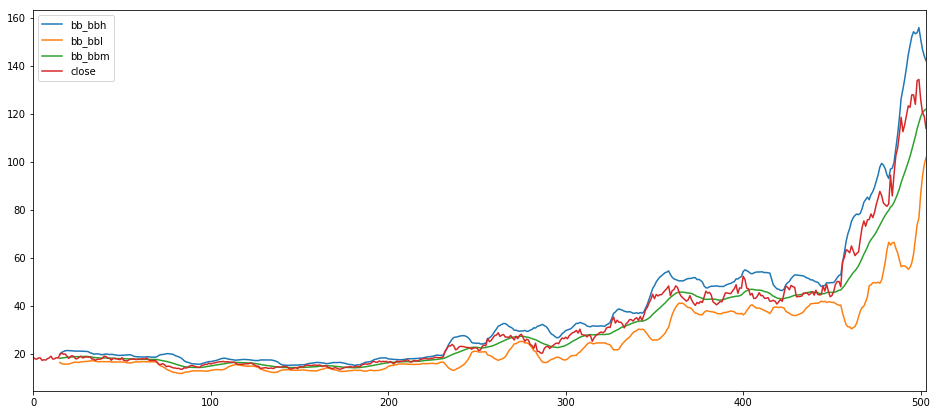

In [13]:
df['bb_bbh'].plot(figsize =[16,7], legend = True)
df['bb_bbl'].plot(legend = True)
df['bb_bbm'].plot(legend = True)
df.close.plot(legend = True)

In [14]:
type(df['bb_bbli'])

pandas.core.series.Series

In [15]:
df.keys()

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'average', 'barCount',
       'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli'],
      dtype='object')

In [16]:
df.__dict__

{'_is_copy': None, '_data': BlockManager
 Items: Index(['date', 'open', 'high', 'low', 'close', 'volume', 'average', 'barCount',
        'bb_bbm', 'bb_bbh', 'bb_bbl', 'bb_bbhi', 'bb_bbli'],
       dtype='object')
 Axis 1: RangeIndex(start=0, stop=504, step=1)
 FloatBlock: [1, 2, 3, 4, 6], 5 x 504, dtype: float64
 IntBlock: slice(5, 9, 2), 2 x 504, dtype: int64
 ObjectBlock: slice(0, 1, 1), 1 x 504, dtype: object
 FloatBlock: slice(8, 9, 1), 1 x 504, dtype: float64
 FloatBlock: slice(9, 10, 1), 1 x 504, dtype: float64
 FloatBlock: slice(10, 11, 1), 1 x 504, dtype: float64
 FloatBlock: slice(11, 12, 1), 1 x 504, dtype: float64
 FloatBlock: slice(12, 13, 1), 1 x 504, dtype: float64, '_item_cache': {'bb_bbl': 0             NaN
  1             NaN
  2             NaN
  3             NaN
  4             NaN
  5             NaN
  6             NaN
  7             NaN
  8             NaN
  9             NaN
  10            NaN
  11            NaN
  12            NaN
  13            NaN
  14   

In [17]:
df['bb_bbhi'].value_counts()

0.0    501
1.0      3
Name: bb_bbhi, dtype: int64

In [18]:
df['bb_bbli'].value_counts()

0.0    504
Name: bb_bbli, dtype: int64

In [19]:
df['bb_bbhi'].head(1) == 0

0    True
Name: bb_bbhi, dtype: bool

In [20]:
df['bb_bbli'].head(1) == 0

0    True
Name: bb_bbli, dtype: bool

In [21]:
df

,date,open,high,low,close,volume,average,barCount,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli
0,2019-01-31,18.3200,18.4600,17.9600,18.41,43978,18.254600,18215,NaN,NaN,NaN,0.0,0.0
1,2019-02-01,18.3000,18.6100,17.7500,17.83,26442,18.060335,13876,NaN,NaN,NaN,0.0,0.0
2,2019-02-04,17.8900,18.0500,17.4700,17.70,20996,17.774915,11582,NaN,NaN,NaN,0.0,0.0
3,2019-02-05,17.7600,18.4350,17.6600,18.21,18658,18.140635,8551,NaN,NaN,NaN,0.0,0.0
4,2019-02-06,18.1900,18.4800,18.0700,18.21,17012,18.304445,8489,NaN,NaN,NaN,0.0,0.0
5,2019-02-07,17.9900,18.0648,16.9900,17.18,37590,17.377830,14830,NaN,NaN,NaN,0.0,0.0
6,2019-02-08,16.9900,17.6500,16.4300,17.46,15484,17.154030,7013,NaN,NaN,NaN,0.0,0.0
7,2019-02-11,17.8300,17.9500,17.1500,17.29,21689,17.380105,10746,NaN,NaN,NaN,0.0,0.0
8,2019-02-12,17.5100,18.2100,17.5100,17.86,36191,17.896170,19208,NaN,NaN,NaN,0.0,0.0
9,2019-02-13,18.1100,18.5000,17.9635,18.20,22676,18.280330,10438,NaN,NaN,NaN,0.0,0.0


In [22]:
temp = datetime.date(datetime.strptime("2020-01-01", "%Y-%m-%d"))

In [23]:
df1 = df[df['date'] > temp]
df1.index = range(len(df1))
df1

,date,open,high,low,close,volume,average,barCount,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli
0,2020-01-02,19.4600,21.8900,19.3000,20.95,116602,20.957725,49031,18.192500,20.649926,15.735074,1.0,0.0
1,2020-01-03,20.5600,22.5899,20.5300,22.08,101646,21.868425,43404,18.512500,22.085138,14.939862,0.0,0.0
2,2020-01-06,21.4600,23.4500,21.4100,23.21,97205,22.570025,40911,18.866875,23.715992,14.017758,0.0,0.0
3,2020-01-07,23.1700,23.2050,22.4200,23.13,65367,22.761420,30688,19.203750,24.860718,13.546782,0.0,0.0
4,2020-01-08,22.9200,23.9100,22.1900,23.84,70873,23.236580,32728,19.575000,26.047678,13.102322,0.0,0.0
5,2020-01-09,24.2900,24.4700,22.8700,23.16,67928,23.438320,30756,19.900000,26.734266,13.065734,0.0,0.0
6,2020-01-10,22.6100,22.6100,20.8300,21.55,100418,21.699400,40560,20.131250,26.868712,13.393788,0.0,0.0
7,2020-01-13,22.3500,22.8327,21.8500,21.99,63524,22.222255,25902,20.400000,26.982890,13.817110,0.0,0.0
8,2020-01-14,21.9600,23.0150,21.9600,22.87,40837,22.730300,20673,20.701875,27.245050,14.158700,0.0,0.0
9,2020-01-15,22.9300,23.2700,22.7600,23.03,35126,23.063870,16822,21.020000,27.396553,14.643447,0.0,0.0


In [24]:
# Initial cash and positions
cash = 100000.0
position = 0
asset = cash

In [25]:
for index, row in df1.iterrows():
    # Buy if current stock price is higher than upper band
    if row['close'] > row['bb_bbh'] and position <= 0: # <=0 because of strategy
        position = cash/row['close'] # Check the share in quantconnect
        
    # Sell if current stock price is lower than lower band
    elif row['close'] < row['bb_bbl'] and position > 0: # >0 because of strategy
        cash = position * row['close']
        # position = 0
    
    # Daily PnL and Asset
    if index > 0:
        df1.loc[index, 'PnL'] = position * (row['close'] - df1.loc[index-1]['close'])  
        df1.loc[index, 'Asset'] = df1.loc[index, 'PnL'] + asset
        asset =  df1.loc[index, 'Asset']
        

C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
df1

,date,open,high,low,close,volume,average,barCount,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,PnL,Asset
0,2020-01-02,19.4600,21.8900,19.3000,20.95,116602,20.957725,49031,18.192500,20.649926,15.735074,1.0,0.0,NaN,NaN
1,2020-01-03,20.5600,22.5899,20.5300,22.08,101646,21.868425,43404,18.512500,22.085138,14.939862,0.0,0.0,5393.794749,105393.794749
2,2020-01-06,21.4600,23.4500,21.4100,23.21,97205,22.570025,40911,18.866875,23.715992,14.017758,0.0,0.0,5393.794749,110787.589499
3,2020-01-07,23.1700,23.2050,22.4200,23.13,65367,22.761420,30688,19.203750,24.860718,13.546782,0.0,0.0,-381.861575,110405.727924
4,2020-01-08,22.9200,23.9100,22.1900,23.84,70873,23.236580,32728,19.575000,26.047678,13.102322,0.0,0.0,3389.021480,113794.749403
5,2020-01-09,24.2900,24.4700,22.8700,23.16,67928,23.438320,30756,19.900000,26.734266,13.065734,0.0,0.0,-3245.823389,110548.926014
6,2020-01-10,22.6100,22.6100,20.8300,21.55,100418,21.699400,40560,20.131250,26.868712,13.393788,0.0,0.0,-7684.964200,102863.961814
7,2020-01-13,22.3500,22.8327,21.8500,21.99,63524,22.222255,25902,20.400000,26.982890,13.817110,0.0,0.0,2100.238663,104964.200477
8,2020-01-14,21.9600,23.0150,21.9600,22.87,40837,22.730300,20673,20.701875,27.245050,14.158700,0.0,0.0,4200.477327,109164.677804
9,2020-01-15,22.9300,23.2700,22.7600,23.03,35126,23.063870,16822,21.020000,27.396553,14.643447,0.0,0.0,763.723150,109928.400955


In [27]:
total_profit = df1['PnL'].sum()
total_profit

443627.6849642005

In [28]:
total_return = total_profit/100000
print("total_return: {:.2%}".format(total_return) )

total_return: 443.63%


In [29]:
df1['Asset%'] = df1['Asset'].pct_change()
std = np.std(df1['Asset%'])
std

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.04242236487861779

In [30]:
# Calculate Sharp Ratio
rf = 0.01 # Assume the risk free return is 1%. The risk free return is too small to affect Sharp Ratio
sr = (total_return - rf) /(std*np.sqrt(len(df1)))
sr

6.32643786705104

# Part II: Live Paper Trading

In [31]:
# Trade after market opens every day at 9:30
# For test, I will not use all of my money.
td = datetime.now()
price = ib.reqMktData(contract, 221).markPrice
if [td.hour, td.minute] == [9, 30]:
    # Buy if current stock price is higher than upper band
    if(df['bb_bbh'].head(1) > price):
        order = MarketOrder('BUY', 100)
        ib.placeOrder(contract, order)
    # Sell if current stock price is lower than lower band
    if(df['bb_bbl'].head(1) < price):
        order = MarketOrder('Sell', 100)
        ib.placeOrder(contract, order)
    

In [32]:
td = datetime.now()

In [33]:
td

datetime.datetime(2021, 3, 1, 11, 2, 34, 113293)

Peer closed connection
